# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico II : Análisis de features de letras

### Libraries

!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install wordcloud
!pip3 install matplotlib
!pip3 install seaborn


### Dependencias y acceso al API

In [1]:
import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import json
import seaborn as sns
import tqdm
from collections import Counter
from nltk import ngrams, bigrams
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt



client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

nlp = spacy.load("en_core_web_sm")

sns.set_context(context='paper')

In [2]:
# aux methods

def song_url_for_request(artist, song_title):
    return "https://api.lyrics.ovh/v1/" + artist + '/' + song_title #str
    # example use:
    # requests.get(song_url_for_request("Death Grips", "Hacker"))
    

def songs_from_album_id(album_id):
    songs = []
    album = sp.album(album_id)
    artist = album['artists'][0]['name']
    for item in album['tracks']['items']:
        track = {}
        track["song_name"] = item['name']
        track["lyrics"]=[]
        track["song_id"] = item['id']
        track["album_name"] = album['name']
        track["album_id"] = album["id"]
        track["artist"] = artist
        songs.append(track)
    return songs    #songs:List[dict]



def genres_by_artist_id(id): #id: str
    artist = sp.artist(id)
    genres = artist['genres']
    return genres    #genres: List[str]

In [3]:
genres_by_artist_id("5K4W6rqBFWDnAN6FQUkS6x")

['chicago rap', 'rap']

## Question:
- How has Kanye West's vocabulary evolved through time?

### From this question we can derive:
- What is his general vocabulary composed of?
- Are there many differences from album to album?
- Can we differentiate epochs in Kanye West's career by analysing his songs' vocabulary?

# Dataset

First we build Kanye West's dataset. We'll be using lyrics from 11 albums;

- Jesus is King
- Kids see ghosts
- ye
- The life of pablo
- Yeezus
- Watch the throne
- My beautiful dark twisted fantasy
- Graduation
- 808s & Heartbreak
- Late Registration
- The college dropout

for a total of 151 songs. After sanitization, 133.

In [4]:
kanye_west=["0FgZKfoU2Br5sHOfvZKTI9",
           "6pwuKxMUkNg673KETsXPUV",
           "2Ek1q2haOnxVqhvVKqMvJe",
           "7gsWAHLeT0w7es6FofOXk1",
           "7D2NdGvBHIavgLhmcwhluK",
           "2P2Xwvh2xWXIZ1OWY9S9o5",
           "20r762YmB5HeofjMCiPMLv",
           "5fPglEDz9YEwRgbLRvhCZy",
           "3WFTGIO6E3Xh4paEOBY9OU",
           "5ll74bqtkcXlKE7wwkMq4g",
           "4Uv86qWpGTxf7fU7lG5X6F"]

In [5]:
ALBUM_IDS = kanye_west


def lemmafy(doc):
    lemmas = []
    for token in doc:
        if not token.is_stop and token.is_alpha:
             lemmas.append(token.lemma_)
    return lemmas

In [6]:
#build base dataset
def build_from_album_ids(album_id_array):
    all_songs = []
    for album in tqdm.tqdm(album_id_array):
        all_songs += songs_from_album_id(album)
    return all_songs
    
all_songs = build_from_album_ids(ALBUM_IDS)

100%|██████████| 11/11 [00:03<00:00,  3.42it/s]


In [7]:
# put song lyrics in dataset
# may take a while
def add_lyrics_to_data(all_songs):
    for song in tqdm.tqdm(all_songs):
        response = requests.get(song_url_for_request(song["artist"],song["song_name"]))
        json_data = json.loads(response.content)
        try:
            lyrics_raw = json_data["lyrics"]
            doc = nlp(lyrics_raw)
            lemmed = lemmafy(doc)
            song["lyrics"]=[word.lower() for word in lemmed]
        except: #found a song without lyrics!
            #print(song["song_name"])
            song["lyrics"]=None
    return all_songs

all_songs = add_lyrics_to_data(all_songs)


100%|██████████| 151/151 [03:37<00:00,  1.44s/it]


In [8]:
songs_base = pd.DataFrame(all_songs)
len(all_songs)


151

In [9]:
# sanitize
bool_series = pd.notnull(songs_base["lyrics"])
songs_base = songs_base[bool_series]
songs_base.head(2)

,album_id,album_name,artist,lyrics,song_id,song_name
1,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[god, king, soldier, ultrabeam, solar, heaven,...",39JRmdKFka1Oe09FoOCPI4,Selah
2,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[father, stretch, stretch, hand, lifelike, lif...",2QpGZOhTCHHiKmpSO9FW4h,Follow God


In [10]:
# build separate dfs for each album
albums = songs_base["album_name"].unique()
albums_dfs = {}
for album in tqdm.tqdm(albums):
    album_df = pd.DataFrame(songs_base[songs_base["album_name"]==album])
    albums_dfs[album] = album_df
albums_dfs.keys()

100%|██████████| 11/11 [00:00<00:00, 1134.96it/s]


dict_keys(['JESUS IS KING', 'KIDS SEE GHOSTS', 'ye', 'The Life Of Pablo', 'Yeezus', 'Watch The Throne (Deluxe)', 'My Beautiful Dark Twisted Fantasy', 'Graduation', '808s & Heartbreak', 'Late Registration', 'The College Dropout'])

### 3) Encontrar los n-gramas (n= 1, 2) más comunes y usarlos en gráficos.
Utilizando las librerías de la celda de abajo obtendremos los conjuntos de 1 y 2 palabras más comunes para cada artista con el que trabajaremos. Luego usaremos los unigramas para graficar una [word-cloud](https://i.imgur.com/8I8aJ1N.png) y un gráfico de distribución de frecuencia para unigramas y bigramas por autor (o de la forma que se adapte a su pregunta).

In [11]:
songs_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 1 to 150
Data columns (total 6 columns):
album_id      133 non-null object
album_name    133 non-null object
artist        133 non-null object
lyrics        133 non-null object
song_id       133 non-null object
song_name     133 non-null object
dtypes: object(6)
memory usage: 7.3+ KB


In [12]:
albums_dfs['JESUS IS KING']["lyrics"]#.keys()

1     [god, king, soldier, ultrabeam, solar, heaven,...
2     [father, stretch, stretch, hand, lifelike, lif...
3     [close, sunday, chick, fil, close, sunday, chi...
4     [yo, yo, favor, accept, lord, saviour, reply, ...
6     [water, water, water, water, purest, water, li...
7     [god, light, darkness, oh, god, god, turn, god...
8     [hand, hand, high, hand, hand, hand, hand, fac...
10    [knee, shall, bow, tongue, confess, jesus, lor...
Name: lyrics, dtype: object

In [13]:
lyrics = list(itertools.chain(songs_base["lyrics"].values))
full_lyrics = [j for i in lyrics for j in i]
len(full_lyrics)

27196

In [14]:
def divide_lyrics_by_album(albums):
    lyrics_by_album = {}
    for album in albums:
        lyrics =  list(itertools.chain(albums_dfs[album]["lyrics"].values))
        lyrics = [j for i in lyrics for j in i]
        lyrics_by_album[album] = lyrics
    return lyrics_by_album
    
lyrics_by_album = divide_lyrics_by_album(albums)

In [15]:
# aux functions
def uniques(ngram_counts,n):
    uniques = []
    for ele in ngram_counts:
        if ngram_counts[ele]==1:
            if n == 1:
                uniques.append(ele[0])
            if n == 2:
                uniques.append(ele)
    return uniques

def ngrams_of_album(album):
    uni_tokens = ngrams(lyrics_by_album[album],1)
    bi_tokens = bigrams(lyrics_by_album[album])
    uni_counts = Counter(uni_tokens)
    bi_counts = Counter(bi_tokens)
    uni_uniques = uniques(uni_counts, 1)
    bi_uniques = uniques(bi_counts, 2)
    #print("\n")
    #print("Unigrams of " + album +" :", uni_counts.most_common(3))
    #print("\n")
    #print("Bigrams of "+album+" :", bi_counts.most_common(3))
    return uni_counts, bi_counts, uni_uniques, bi_uniques

def plot_wordcloud_from_string(text, title):
    stopwords=["nada","hey","la","oh","woah","hmm","mm","mhm",
               "bam","chorus","verse","dem","feat","huh","gwaan","yeah","ay"]
    wordcloud = WordCloud(width=880, height=480, 
                          max_font_size = 1120,margin=0,
                          background_color="black",relative_scaling=.5,
                          collocations=False,
                         stopwords=stopwords).generate(text) 
                            #collocations= False so it doesn't show bigrams
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear',)
    plt.axis("off")
    plt.title('WORD CLOUD of '+title, fontsize = 20)
    plt.margins(x=0, y=0)
    plt.show()
    return wordcloud

Now that we have the lyrics across all albums in a list, we can count the unigrams and the bigrams.

In [16]:
uni_tokens = ngrams(full_lyrics,1)
bi_tokens = bigrams(full_lyrics)
bi_counts = Counter(bi_tokens)
uni_counts = Counter(uni_tokens)
#print([(item, counts.count(item)) for item in sorted(set(bi_tokens))])
uni_uniques = uniques(uni_counts, 1)
print("Unigrams:", uni_counts.most_common(5))
print("\n")
print("Bigrams:", bi_counts.most_common(5))
print("\n")
print("Amount of uniques: ", len(uni_uniques))

Unigrams: [(('know',), 477), (('like',), 468), (('get',), 346), (('be',), 287), (('love',), 251)]


Bigrams: [(('la', 'la'), 79), (('movin', 'forward'), 67), (('kanye', 'west'), 66), (('go', 'to'), 65), (('water', 'water'), 59)]


Amount of uniques:  2434


We can also divide this analysis by album

In [17]:
# get different data of each album
ye_uni_counts, ye_bi_counts, ye_uni_uniques, ye_bi_uniques = ngrams_of_album("ye")
yeezus_uni_counts, yeezus_bi_counts, yeezus_uni_uniques, yeezus_bi_uniques = ngrams_of_album("Yeezus")
grad_uni_counts, grad_bi_counts, grad_uni_uniques, grad_bi_uniques = ngrams_of_album("Graduation")
pablo_uni_counts, pablo_bi_counts, pablo_uni_uniques, pablo_bi_uniques = ngrams_of_album("The Life Of Pablo")
heart_uni_counts, heart_bi_counts, heart_uni_uniques, heart_bi_uniques = ngrams_of_album("808s & Heartbreak")
jik_uni_counts, jik_bi_counts, jik_uni_uniques, jik_bi_uniques = ngrams_of_album("JESUS IS KING")
kids_uni_counts, kids_bi_counts, kids_uni_uniques, kids_bi_uniques = ngrams_of_album("KIDS SEE GHOSTS")
throne_uni_counts, throne_bi_counts, throne_uni_uniques, throne_bi_uniques = ngrams_of_album("Watch The Throne (Deluxe)")
fan_uni_counts, fan_bi_counts, fan_uni_uniques, fan_bi_uniques = ngrams_of_album("My Beautiful Dark Twisted Fantasy")
reg_uni_counts, reg_bi_counts, reg_uni_uniques, reg_bi_uniques = ngrams_of_album("Late Registration")
drop_uni_counts, drop_bi_counts, drop_uni_uniques, drop_bi_uniques = ngrams_of_album("The College Dropout")

### 4) Escribir un informe

Este informe tiene que describir qué datos que obtuvieron, el volumen de estos (# de canciones del artista, # de canciones de la competencia, etc), una explicación de cómo estos se relacionan con la pregunta planteada, cómo ayudan a responderla y los resultados que obtuvieron. Usar la celda de abajo con formato markdown.




# Report

## Dataset

The Kanye West dataset was built with the lyrics of the 11 albums that compise Kanye West's discography:

- Jesus is King
- Kids see ghosts
- ye
- The life of pablo
- Yeezus
- Watch the throne
- My beautiful dark twisted fantasy
- Graduation
- 808s & Heartbreak
- Late Registration
- The college dropout

for a total of 151 songs. After sanitization **133 songs** remained. Those correspond with the songs that had lyrics available in the API used for lyrics retrieval, and non instrumental songs.

Some of the albums of this dataset aren't cannonically "Kanye West" albums, or attributed to him, but his influence as a producer has been strong enough to be considered "Kanye West" albums. Also, the Spotify lists them all as such.

Since the question that guides this reseach tries to approach Kanye's whole career through his lyrics, all his albums have been considered.

## Question:

In this report I'm going to explore the dataset built around Kanye West's songs in order to answer the following question

> How has Kanye West's vocabulary evolved through time?

From this question we can derive the following sub-questions:

> What is his general vocabulary composed of?

> Are there major differences from album to album?

> Can we differentiate epochs in Kanye West's career by analysing his songs' vocabulary?

## General Analysis

First let's make a through analysis of the vocabulary of Kanye West's career as a whole.

We can see a word cloud of all the dataset's lyrics.

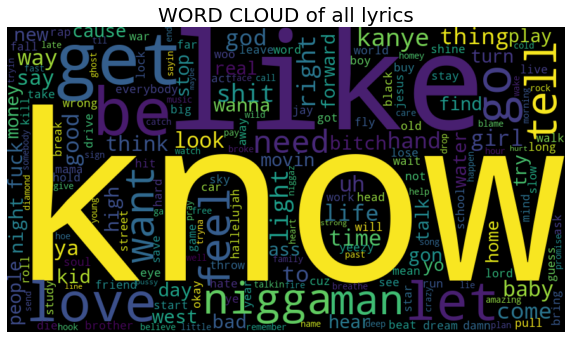

In [18]:
text_from_full_lyrics = " ".join(full_lyrics)
all_lyrics_plot = plot_wordcloud_from_string(text_from_full_lyrics, "all lyrics")

We can see the predominance of the word *know*, which will be seen as most common in most of Kanye's albums. The same case happens in a less pronounced way with *love* and *light*.

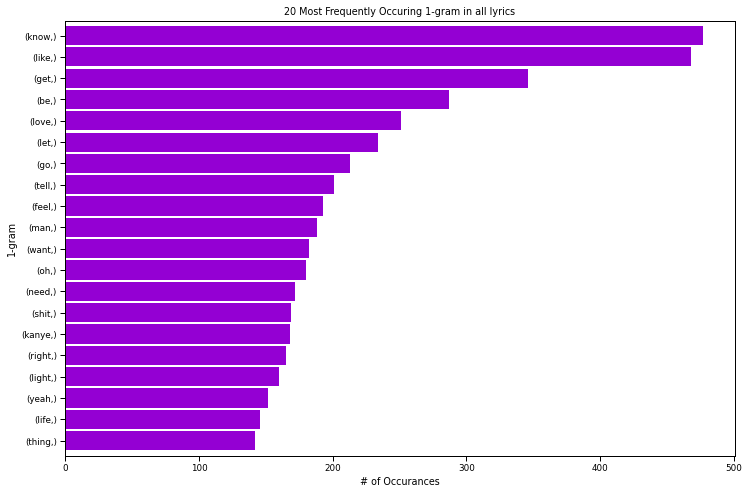

In [19]:
def plot_freq(lyrics,*,n_of_ngram, amount, more_info):
    ngrams_series =pd.Series(nltk.ngrams(full_lyrics,n_of_ngram)).value_counts()[:20]
    ngrams_series.sort_values().plot.barh(color='darkviolet', width=.9, figsize=(12, 8))
    plt.title(str(amount)+' Most Frequently Occuring '+str(n_of_ngram)+'-gram'+' in '+more_info)
    plt.ylabel(str(n_of_ngram)+'-gram')
    plt.xlabel('# of Occurances')

plot_freq(full_lyrics, n_of_ngram=1,amount=20,more_info="all lyrics")

We can get a more quantifiable overview of the unigrams in this unigram frequencies plot.

*know* and *like* surpass the rest of the unigrams by a large margin.

Following up we have a few common verbs in the english language *get*, *let*, *go*, *be*.

More interesting repeating nouns are *love*, *feel*, *shit*, *life*, *man*. 

Kanye West's career's vocabulary, in general, involves everyday words, that talk about what most people consider important in their lives -love, feelings, possessions-. There's an interest in reflecting on what a human possesses, what they can acquire, and what that means.

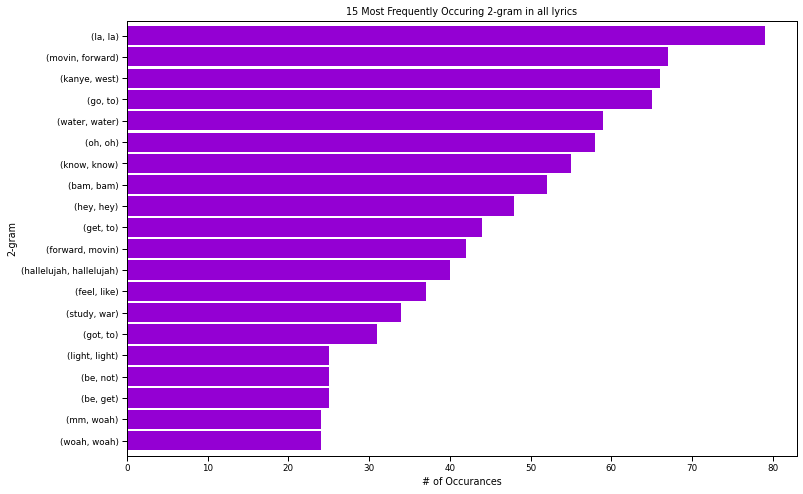

In [20]:
plot_freq(full_lyrics, n_of_ngram=2,amount=15,more_info="all lyrics")

We can see that *Kanye West* is the most recurring bigram. This has more to do with the way rap's lyrics are written down than with Kanye's vocabulary. More on this on **Problems found** section.

Other than that particular case, *la la* is the most frequent bigram, and it corresponds with other rythmic onomatopoeia, like *bam bam*, *oh oh*, *mm woah* , *hey hey*. 

In most cases, frequent bigrams are the result of repeating words.

More interesting for a qualitative analysis are the cases where different words that happen to be together frequently. That's the case with:

* Moving forward, 
* study war, 
* get to, 
* feel like,
* go to, 
* look like,
* be get, 
* tell ya

From that we can form a more meaninful overview of the concepts that are most frequently expressed in Kanye's lyrics. There is an interest in expressing feelings, expressing both internal and external movement, to talk about appearence and to talk about what has been talked about, as in to tell stories through the memories of dialogues. 

From the 27385 word utterances that compose the lyrics dataset, 2434 are unique words. That is a proportion of 8.9% of the words said in total. There is a stronger interest in talking through simple, everyday words which is also shown in the average length of a word in the overall lyrics, being ~5 character per word  - unique words seem to have almost the same behavior, with an average of 6 chars in each word.

In [21]:
lengths_all =[len(word) for word in full_lyrics]
lengths_uniques = [len(word) for word in uni_uniques]
avg_uniques=sum(lengths_uniques)/len(lengths_uniques)
avg_all=sum(lengths_all)/len(lengths_all)
print("Average length of a word: ", round(avg_all,3))
print("Average length of an unique word: ", round(avg_uniques,3))

Average length of a word:  4.609
Average length of an unique word:  6.342


In [22]:
lengths_count = Counter(lengths_all)
lengths_count = dict(lengths_count)
unique_lengths_count = Counter(lengths_uniques)
unique_lengths_count = dict(unique_lengths_count)

In [23]:
def word_counters(lyrics, uni_uniques):
    lengths_all =[len(word) for word in lyrics]
    lengths_uniques = [len(word) for word in uni_uniques]
    print(len(lengths_uniques))
    avg_all=sum(lengths_all)/len(lengths_all)
    avg_uniques=sum(lengths_uniques)/len(lengths_uniques)
    
    print("Average length of a word: ", round(avg_all,3))
    print("Average length of an unique word: ", round(avg_uniques,3))
    lengths_count = Counter(lengths_all)
    unique_lengths_count = Counter(lengths_uniques)
    return dict(lengths_count), dict(unique_lengths_count)

def avg_word_count(lyrics, uni_uniques):
    lengths_all =[len(word) for word in lyrics]
    lengths_uniques = [len(word) for word in uni_uniques]
    print(len(lengths_uniques))
    avg_all=sum(lengths_all)/len(lengths_all)
    avg_uniques=sum(lengths_uniques)/len(lengths_uniques)
    len_lyrics = len(lengths_all)
    len_uniques = len(lengths_uniques)
    return avg_all, avg_uniques, len_lyrics, len_uniques

In [24]:
def plot_freq_length_word(length_count, *, more_info, color='violet'):
    word_length_series =pd.Series(length_count)
    word_length_series.sort_values().plot.barh(color=color, width=.9, figsize=(12, 8))
    plt.title(' Most Frequent length of word '+ more_info)
    plt.ylabel('word length')
    plt.xlabel('# of Occurances')

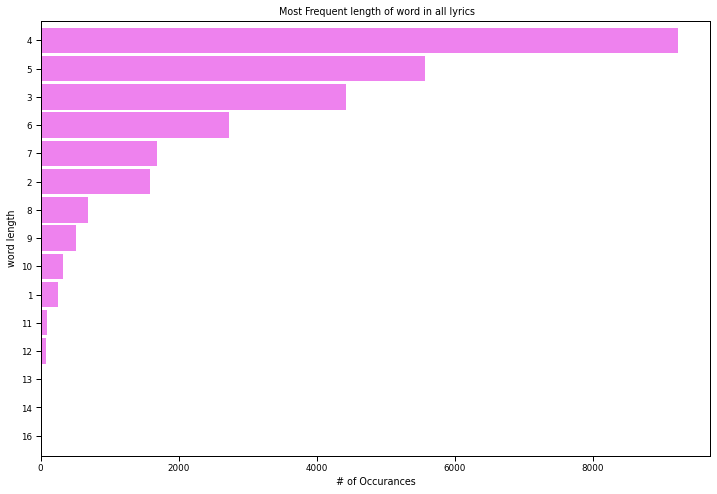

In [25]:
plot_freq_length_word(lengths_count,more_info="in all lyrics")

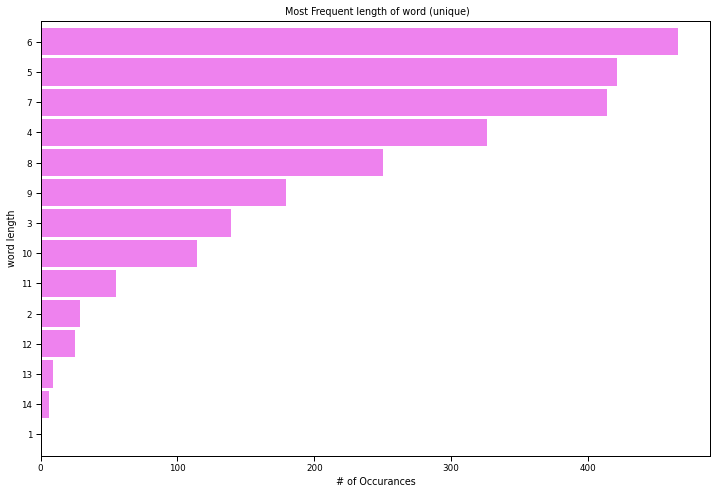

In [26]:

plot_freq_length_word(unique_lengths_count, more_info="(unique)")

## Analysis through the albums

In order to analyse the vocabulary through the albums let's see the wordclouds in order of the albums release.

In [27]:
albums_in_order = ['The College Dropout',
                   'Late Registration',
                   'Graduation',
                   '808s & Heartbreak',
                   'My Beautiful Dark Twisted Fantasy',
                   'Watch The Throne (Deluxe)',
                   'Yeezus',
                   'The Life Of Pablo',
                   'ye',
                   'KIDS SEE GHOSTS',
                   'JESUS IS KING',
                  ]
uni_uniques_in_order=[drop_uni_uniques,reg_uni_uniques,
             grad_uni_uniques,heart_uni_uniques,
             fan_uni_uniques,throne_uni_uniques,
             yeezus_uni_uniques,pablo_uni_uniques,
             ye_uni_uniques,kids_uni_uniques,jik_uni_uniques,
             ]


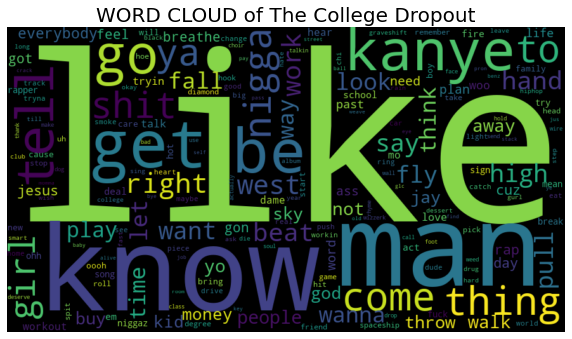

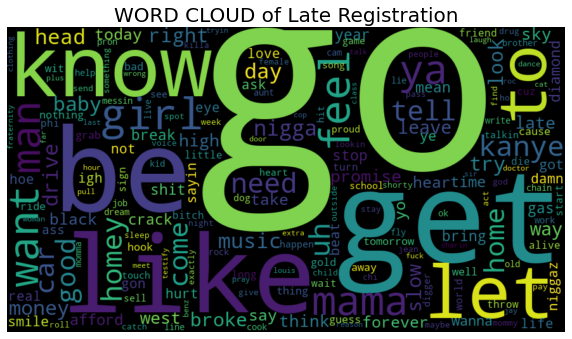

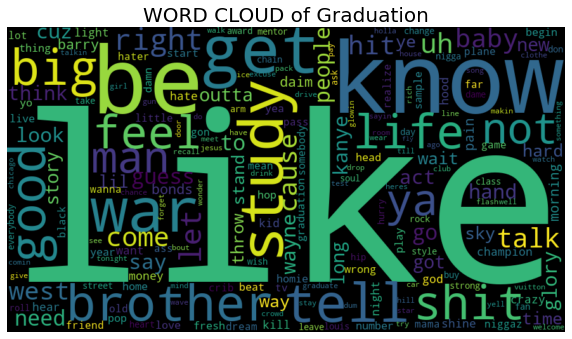

In [28]:
for album in albums_in_order[:3]:
    plot_wordcloud_from_string(" ".join(lyrics_by_album[album]), album)

These first three albums appear to be lyrically similar.

In **Graduation** we can see a few distinct words pop up to the front; *study*, *war*, *life*. In general the words are more conceptually heavy, differentiating itself from other wordclouds of this batch.

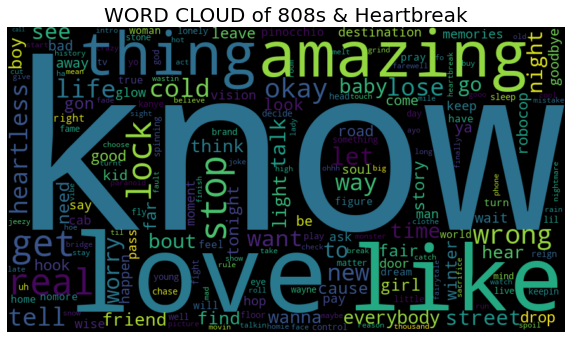

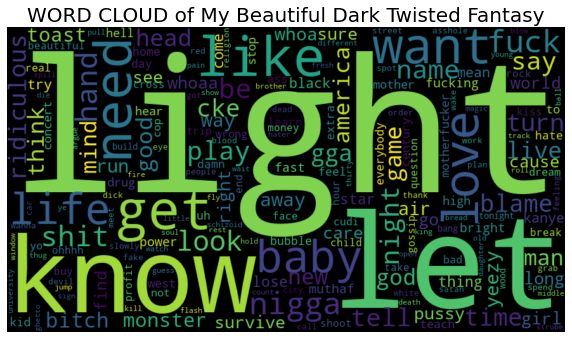

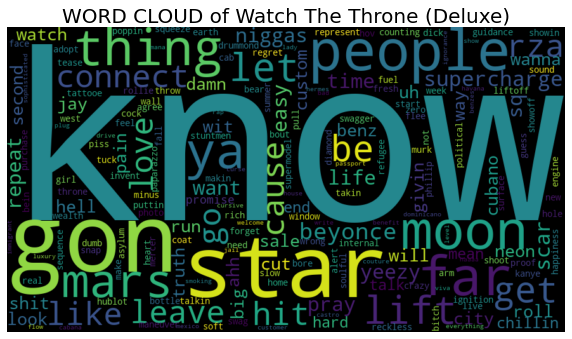

In [29]:
for album in albums_in_order[3:6]:
    plot_wordcloud_from_string(" ".join(lyrics_by_album[album]), album)

In **808s & Heartbreak** we can see *love* stepping to the front for the first time in Kanye's career. In general the rest of the common words appear to be more conceptually charged, like the case with **Graduation**.

Both **MBDTF** and **Watch the Throne** appear to be very different to **808s**. 

In **MBDTF** *light* appears to be the most common word, alongside need, want, love, get, life. 

In **Watch the Throne** astronomical words pop up *star*, *moon*, *mars*.

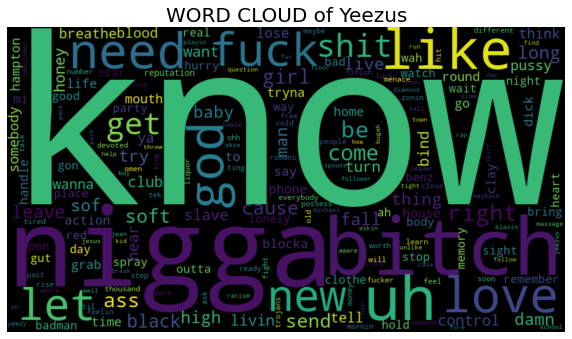

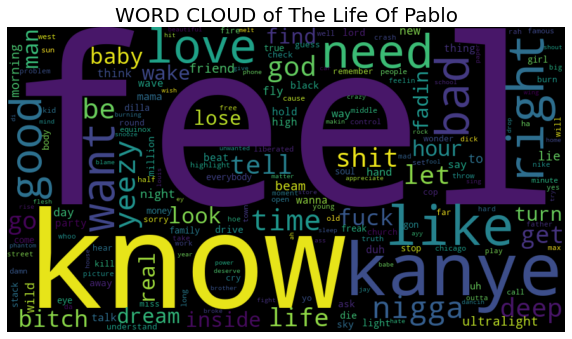

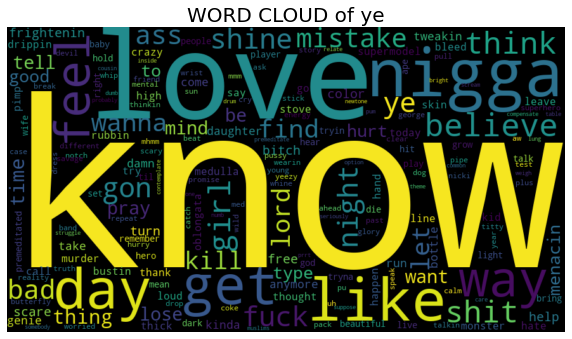

In [30]:
for album in albums_in_order[6:9]:
    plot_wordcloud_from_string(" ".join(lyrics_by_album[album]), album)

In this batch we can see the words *nigga* and *shit* come to the front.

In the first two wordclouds *bitch* is also one of the most common words.

Alongside these words, *god*, *love* and *shit* coexist in all three wordclouds.

In **ye** *bitch* is no longer present, we can see *love* stepping up, alongside *shine*, *think*, *believe*, *night*, *feel*, *mistake*, *lord*, *pray*, *fuck*.

In this batch we can see a few lyrical focus changes:

**Yeezus** introduced in Kanye's lyrics profanity, and a lot of sex focused lyrics. In **TLOP** the vocabulary augments in complexity,  "warming up" from the banal sex mentions to a more feelings-focused vocabulary. The batch concludes with the very dichotomical vocabulary of **ye**.

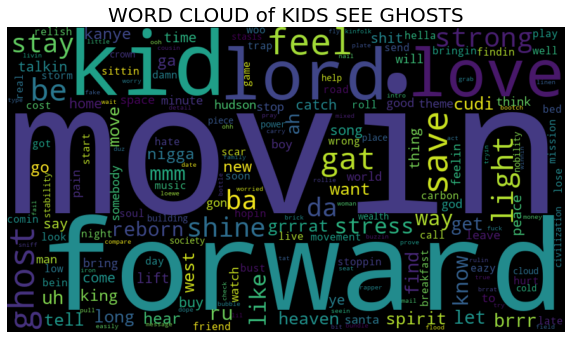

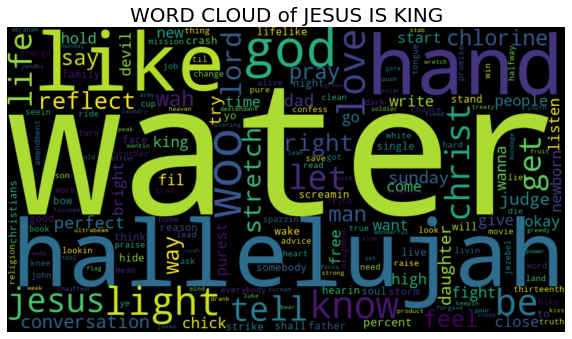

In [31]:
for album in albums_in_order[9:]:
    plot_wordcloud_from_string(" ".join(lyrics_by_album[album]), album)

The last batch concludes with a very sharp turn around in Kanye's career. Both of these albums' lyrics are conceptually charged and concentrated, showing a very big change towards a more spiritual lyric exploration. The last wordcloud could very much belong to a gospel album.

Other than **Graduation**, **808s**, **KIDS SEE GHOSTS** and **JESUS IS KING**, Kanye's lyrics have been what one would expect from a "generic rapper".

But these exceptions show up first as warm ups, that lead to to the more concentrated lyrical explorations of Kanye's late career.

Now let's analyze word lengths per album.

In [42]:
length_data_by_album = []
i=0
for album in albums_in_order:
    album_data = {}
    album_data["album"]=album
    album_length_count, album_uniques_length_count, amount_words, amount_uniques = avg_word_count(lyrics_by_album[album],uni_uniques_in_order[i])
    album_data["avg_word_length"]=album_length_count
    album_data["unique_avg_word_length"]=album_uniques_length_count
    album_data["amount_words"]=amount_words
    album_data["amount_uniques"]=amount_uniques
    length_data_by_album.append(album_data)
    i+=1
length_data_by_album_df = pd.DataFrame(length_data_by_album)

964
806
566
217
796
232
471
595
351
272
265


In [33]:
length_data_by_album_df.describe()

,amount_uniques,amount_words,avg_word_length,unique_avg_words_length
count,11.000000,11.000000,11.000000,11.000000
mean,503.181818,2472.363636,4.639345,5.582618
std,263.055438,1656.235507,0.171890,0.235354
min,217.000000,473.000000,4.448168,5.221198
25%,268.500000,1275.000000,4.500632,5.421147
50%,471.000000,1880.000000,4.626100,5.581741
75%,695.500000,3612.500000,4.730561,5.755041
max,964.000000,5980.000000,5.037645,6.006224


In [63]:
# Subset of features that we will analyse in this sereach
features = ["album","avg_word_length","unique_avg_word_length"]
df1 = length_data_by_album_df[features]
df1

,album,avg_word_length,unique_avg_word_length
0,The College Dropout,4.573077,6.006224
1,Late Registration,4.489367,5.736973
2,Graduation,4.486800,5.598940
3,808s & Heartbreak,4.511897,5.221198
4,My Beautiful Dark Twisted Fantasy,4.767235,5.834171
5,Watch The Throne (Deluxe),4.748414,5.461207
6,Yeezus,4.631383,5.581741
7,The Life Of Pablo,4.626100,5.773109
8,ye,4.712707,5.404558
9,KIDS SEE GHOSTS,4.448168,5.352941


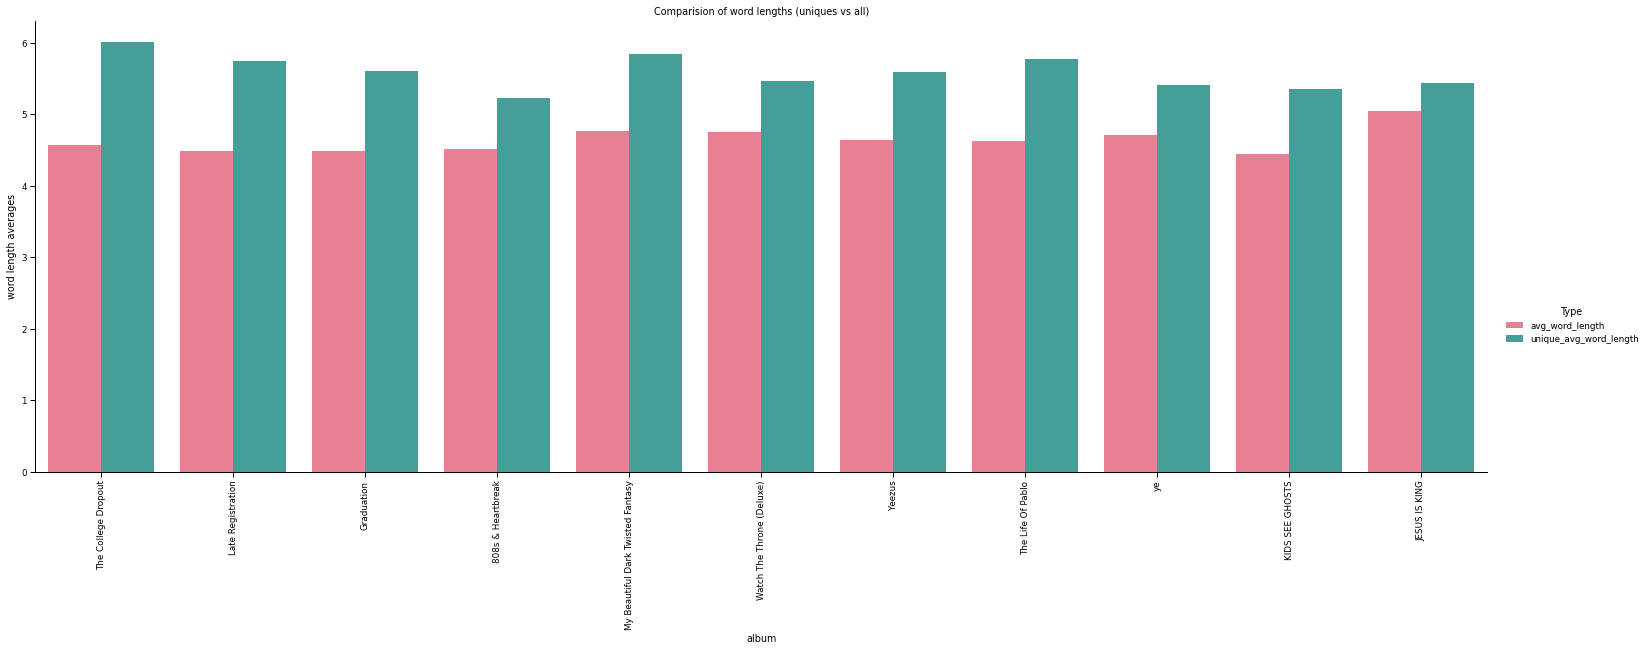

In [62]:
df2 = pd.melt(df1, id_vars="album", var_name="avg_word_length", value_name="unique_avg_word_length")
ax =sns.catplot(x='album', y='unique_avg_word_length',hue='avg_word_length', 
                data=df2, kind='bar',palette=sns.color_palette("husl", 2),height=7,aspect=3,legend_out=True)
ax._legend.set_title("Type")
ax.set_ylabels("word length averages")
ax.set_xticklabels(rotation=90)
plt.title('Comparision of word lengths (uniques vs all)')
plt.show(ax)

In general, through Kanye's career, the unique words differ in length with the common word uttered, showing a disconnection - these unique words contrasting in tone with the more frequent ones; a vocabulary made of simple, short, everyday words, with no big conceptual charge, and some longer words popping up, offering variation. An interpretation of this fact could be the search of a relatable way of expressing, trying to mimic a casual tone, lighthearted talk, etc.

**JESUS IS KING** has the maximum average word length, showing the narrowest difference between word lengths in unique words and in common, repeating words. This shows **JIK** conceptual lyrical exploration going beyond everyday talk. Coupled with the wordcloud of this album, from which we can see the spiritual references as a major lyrical focus, we can conclude this is the most experimental Kanye album and a major lyrical breakthrough.

## Problems Found

The lyrics retrieved in the dataset construction part of the report need further sanitization. As per rap lyrics tradition, they contain sentences that don't belong to the lyrics themselves, like the usual 

[*rapper name*]

or *feat*, *featuring*, *verse*, *chorus*. They have been taken out of the wordclouds manually, but remain in the dataset. This could be a fertile ground of further work, for more see the **Further work** section.

Since this is a NLP project involving rap lyrics, there has been a dialect problem. Rap is not "plain english", it is in AAVE dialect. This means the tokenization and lemmatization process hasn't been perfect, and in the dataset there remain non-lemmas, some utterances have not been identified as stopwords, etc. This has made the frequencies and distribution analysis difficult, onomatopeias were not detected by the library used, nor tokens correctly lemmatized. Since this is not the focus of this research, it has been manually handled for the analysis and visualization, but the problem remains in the dataset.

## Further Work

From the issues mentioned in the **Problems Found** section a lot of research topics spawn. 

For example, what Python libraries exist that are adept for analysing different dialects of the english language, and how do they perform? How do you measure and compare their performances? How many of these libraries are adept at the AAVE dialect? what is the ethical analysis of this fact? If the main libraries of NLP are only adept at research of some dialects and not others, what does that mean ethically for the discipline itself? What should be the default, minimum, acceptable performance of an NLP library for "minority" dialects? Evenmore research topics spawn from each one of these questions.

The rap lyrics present genre-like features. Do Python/NLP tools exist that could aid further research on this topic? How could we best caracterize Rap and its vocabulary -both spoken and written?

Beyond these issues, for continuing analysis of Kanye's lyrics through his career, I propose studying the amount of words uttered per album. This can't be done straightforwardly, since a longer album will have more words uttered, the same happens with albums with longer songs. So there has to be some form of normalization alongside those features. Another possible methodology would be to make a random sample of, say, 5 songs per album and to take that sample as representative of the whole album. A methodological research could spawn from comparing both of these approaches.

With this issue clarified, for continuing a Kanye centered analysis, the focus can be put on the words uttered once per album -the so called "uniques" throughout this research. Is there knowledge to be gained from these? In a more general sense, for a bigger research, what do "unique" words say about an album's theme? What do they say about an artist's career? What do they say about different genres, and about different genres throughout time? Do they change through time? How so?

In conclusion, this is a very fertile research field.

## Conclusions

Throughout his career, Kanye has made a few lyrical leaps. Going from introducing more conceptual themes, to the proliferation of profanity and a more "vulgar" period, and ending up, as per 2020, in a very conceptually concise, lyrical point of view. He proposes a theme which goes beyond what is expected of a mainstream rapper like himself.

In this research a lot of research topics for further investigation have been found.